# Architecture
- langchain-core: Base abstraction for chat models and other components
- Integration packages (eg. langchain-openai, langchain-anthropic, etc.): Important integrations have been split into lightweight packages that are co-maintained by the Langchain team and the integration developers.
- langchain: Chains, agents and retrieval strategies that make up an application's cognitive architecture.
- langchain-community: Third-party integration that are community maintained.
- langgraph: Orchestration framework for combining Langchain components into production ready applications with persistence streaming and other key featues

### BaseChatModel
Base class for chat models

Method|Input|Output|Description|
|--|--|--|--|
|invoke|str List[dict tuple BaseMessage] PromptValue|BaseMessage|A single chat model call.|
|ainvoke|"|BaseMessage|Defaults to running invoke in an async executor|
|stream|‘’’|Iterator[BaseMessageChunk]|Defaults to yielding output of invoke.|
|astream|‘’’|AsyncIterator[BaseMessageChunk]|Defaults to yielding output of ainvoke.|

RunnableLambda converts python callable into a runnable.

Callable is any object called like a function, eg. Functions, Methods, Classes, Instances with method `__call__`.

Runnable is a interface that has invoke method.

So we add the invoke method to the callable when we convert to RunnableLambda.

In [13]:
# This is a RunnableLambda
from langchain_core.runnables import RunnableLambda

def add_one(x: int) -> int:
    return x + 1

runnable = RunnableLambda(add_one)

runnable.invoke(1) # returns 2
runnable.batch([1, 2, 3]) # returns [2, 3, 4]

# Async is supported by default by delegating to the sync implementation
await runnable.ainvoke(1) # returns 2
await runnable.abatch([1, 2, 3]) # returns [2, 3, 4]

async def add_one_async(x: int) -> int:
    return x + 1

runnable = RunnableLambda(add_one, afunc=add_one_async)
runnable.invoke(1) # Uses add_one
await runnable.ainvoke(1) # Uses add_one_async

2

#### format_docs

In [9]:
from typing import List
from langchain.schema import Document 
from langchain_core.runnables import RunnableLambda

def format_docs(docs: List[Document]) -> str:
    '''Format the docs.'''
    return ", ".join([doc.page_content for doc in docs])

format_docs = RunnableLambda(format_docs)

#### some_tool

In [15]:
from langchain_core.tools import tool

@tool
def some_tool(x: int, y: str) -> dict:
    '''Some_tool.'''
    return {"x": x, "y": y}

#### prompt

In [40]:
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate.from_messages(
    [("system", "You are Cat Agent 007"), ("human", "{question}")]
).with_config({"run_name": "my_template", "tags": ["my_template"]})

In [41]:
from langchain_core.runnables import RunnableLambda

async def reverse(s: str) -> str:
    return s[::-1]

chain = RunnableLambda(func=reverse)

events = [
    event async for event in chain.astream_events("hello", version="v2")
]

In [42]:
events

[{'event': 'on_chain_start',
  'data': {'input': 'hello'},
  'name': 'reverse',
  'tags': [],
  'run_id': 'f6e7e0f2-20db-4354-a7c1-c1e06f2408a6',
  'metadata': {},
  'parent_ids': []},
 {'event': 'on_chain_stream',
  'run_id': 'f6e7e0f2-20db-4354-a7c1-c1e06f2408a6',
  'name': 'reverse',
  'tags': [],
  'metadata': {},
  'data': {'chunk': 'olleh'},
  'parent_ids': []},
 {'event': 'on_chain_end',
  'data': {'output': 'olleh'},
  'run_id': 'f6e7e0f2-20db-4354-a7c1-c1e06f2408a6',
  'name': 'reverse',
  'tags': [],
  'metadata': {},
  'parent_ids': []}]

## Chat Models

In [8]:
import getpass
import os

if not os.environ.get("LANGSMITH_API_KEY"):
  os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key for LangSmith: ")

In [2]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "pr-overcooked-push-81"

In [11]:
import langsmith
from langchain_core.tracers.context import tracing_v2_enabled
from langchain.chat_models import init_chat_model

langsmith_client = langsmith.Client(
 api_key=os.environ.get("LANGSMITH_API_KEY"),
 api_url='https://api.smith.langchain.com'
)
with tracing_v2_enabled(client=langsmith_client, project_name="default"):
    model = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")
    model.invoke("Hello, world!")

In [25]:
from langchain.chat_models import init_chat_model

model = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")
model.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'qwen2.5-coder:14b', 'created_at': '2025-02-20T09:07:13.435388468Z', 'done': True, 'done_reason': 'stop', 'total_duration': 196595805, 'load_duration': 8046258, 'prompt_eval_count': 33, 'prompt_eval_duration': 24000000, 'eval_count': 10, 'eval_duration': 161000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-9ed2fd74-af36-41e6-9109-c53ad43b0b61-0', usage_metadata={'input_tokens': 33, 'output_tokens': 10, 'total_tokens': 43})

In [1]:
from langchain_ollama import ChatOllama
import langsmith
from langchain_core.tracers.context import tracing_v2_enabled
langsmith_client = langsmith.Client(
 api_key='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',
 api_url='https://api.smith.langchain.com'
)
llm = ChatOllama(
    model="qwen2.5-coder:14b",
    temperature=0,
    # other params...
)
from langchain_core.messages import AIMessage

messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
with tracing_v2_enabled(client=langsmith_client, project_name="default"):
    ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'aime programmer.", additional_kwargs={}, response_metadata={'model': 'qwen2.5-coder:14b', 'created_at': '2025-02-20T20:48:27.384708338Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1888507642, 'load_duration': 1476506744, 'prompt_eval_count': 33, 'prompt_eval_duration': 98000000, 'eval_count': 6, 'eval_duration': 89000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-9dc166ca-0432-451c-a23b-2a3f6be96ba4-0', usage_metadata={'input_tokens': 33, 'output_tokens': 6, 'total_tokens': 39})

In [2]:
!uv pip install langchain
!uv pip install -U langchain-ollama

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 10ms
Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 26 packages in 297ms                                        
Audited 26 packages in 0.16ms


In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

deepseek_model = OllamaLLM(model="deepseek-r1:14b")

deepseek_chain = prompt | deepseek_model

deepseek_chain.invoke({"question": "What is LangChain?"})

'<think>\nAlright, I\'m trying to figure out what LangChain is. I\'ve heard the term before in the context of AI and machine learning, but I\'m not exactly sure what it entails. Let me start by breaking down the name itself—LangChain. It sounds like a combination of "language" and something else, maybe related to chaining or processes.\n\nI remember that in AI, especially with large language models (LLMs), there\'s been a lot of talk about chaining different tasks together to make them more efficient or powerful. So perhaps LangChain is a framework that helps in creating these chains of operations? I think I\'ve heard it mentioned alongside tools like Chains, Agents, and something called the LangChain API.\n\nLet me consider what each part could mean. "Chains" in this context might refer to sequences of steps where an AI model interacts with other models or external tools. For example, maybe a chain involves first using one model for text generation and then another for image processin

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

qwen_model = OllamaLLM(model="qwen2.5-coder:14b")

qwen_chain = prompt | qwen_model

qwen_chain.invoke({"question": "What is LangChain?"})

'LangChain is an open-source framework designed to simplify the development of language models and applications built on them. Here’s how we can break down its key features and components:\n\n1. **Modularity**: LangChain emphasizes modularity, allowing developers to easily integrate different components such as data connectors, text processing tools, and machine learning models.\n\n2. **Ease of Use**: It provides a user-friendly interface that abstracts the complexities of language model development, making it accessible for both beginners and experienced developers.\n\n3. **Scalability**: The framework is designed to scale efficiently, supporting large datasets and high traffic loads by leveraging cloud resources and distributed computing.\n\n4. **Integration with Existing Tools**: LangChain can integrate seamlessly with existing tools and platforms, enhancing the capabilities of pre-existing applications without significant overhauls.\n\n5. **Community Support**: Being open-source, L

In [3]:
qwen_chain.invoke({"question": "What is 5*5?"})

"Step 1: Understand the problem.\nThe question is asking for the product of 5 and 5.\n\nStep 2: Recall multiplication basics.\nMultiplication is essentially repeated addition. When we multiply 5 by 5, it means adding 5 to itself 5 times.\n\nStep 3: Perform the calculation.\nLet's add 5 to itself 5 times:\n5 + 5 = 10\n10 + 5 = 15\n15 + 5 = 20\n20 + 5 = 25\n\nStep 4: Verify the result.\nWe can double-check our answer by using a different method, such as multiplying in reverse (5 * 5 is the same as 5 * 5).\n\nAnswer: The product of 5 and 5 is 25."

In [4]:
deepseek_chain.invoke({"question": "What is 5*5?"})

'<think>\nFirst, I need to identify the two numbers that are being multiplied in the expression 5 times 5.\n\nNext, I will perform the multiplication operation by multiplying these two numbers together.\n</think>\n\n**Solution:**\n\nTo find the product of \\(5 \\times 5\\), follow these simple steps:\n\n1. **Identify the Numbers:**\n   - The first number is **5**.\n   - The second number is also **5**.\n\n2. **Multiply the Two Numbers:**\n   \n   \\[\n   5 \\times 5 = 25\n   \\]\n\n3. **Final Answer:**\n\n   \\[\n   \\boxed{25}\n   \\]'

In [7]:
qwen_chain.invoke({"question": "What is 2555*2555?"})

"To calculate \\(2555 \\times 2555\\), we can break down the multiplication into simpler steps using the distributive property of multiplication over addition.\n\nFirst, let's express 2555 as a sum of more manageable numbers:\n\\[ 2555 = 2000 + 500 + 50 + 5 \\]\n\nNow, we can use the distributive property to multiply each part by itself:\n\n1. \\(2000 \\times 2000\\)\n2. \\(2000 \\times 500\\)\n3. \\(2000 \\times 50\\)\n4. \\(2000 \\times 5\\)\n\nAnd repeat for the second part:\n\n1. \\(500 \\times 2000\\)\n2. \\(500 \\times 500\\)\n3. \\(500 \\times 50\\)\n4. \\(500 \\times 5\\)\n\nAnd so on, but since multiplication is commutative (\\(a \\times b = b \\times a\\)), we only need to calculate each unique pair once.\n\nLet's calculate them step by step:\n\n1. \\(2000 \\times 2000 = 4,000,000\\)\n2. \\(2000 \\times 500 = 1,000,000\\)\n3. \\(2000 \\times 50 = 100,000\\)\n4. \\(2000 \\times 5 = 10,000\\)\n\nNow, add these results together:\n\\[ 4,000,000 + 1,000,000 + 100,000 + 10,000 = 5,

In [8]:
deepseek_chain.invoke({"question": "What is 2555*2555?"})

"<think>\nTo calculate \\(2555 \\times 2555\\), I recognize that squaring a number can be done using the formula \\((a + b)^2 = a^2 + 2ab + b^2\\). \n\nFirst, I'll break down 2555 into 2500 and 55. So, \\(2555 = 2500 + 55\\).\n\nNext, I'll square each part separately:\n- Squaring 2500 gives me \\(2500^2 = 6,250,000\\).\n- Squaring 55 gives me \\(55^2 = 3,025\\).\n\nThen, I'll calculate the cross term: \\(2 \\times 2500 \\times 55 = 275,000\\).\n\nFinally, I'll add all these results together:\n\\(6,250,000 + 275,000 + 3,025 = 6,528,025\\).\n</think>\n\n**Solution:**\n\nTo find \\(2555 \\times 2555\\), we can use the formula for squaring a number:\n\n\\[\n(a + b)^2 = a^2 + 2ab + b^2\n\\]\n\nLet's break down \\(2555\\) into two parts for easier calculation.\n\n1. **Decompose the Number:**\n   \n   \\[\n   2555 = 2500 + 55\n   \\]\n\n2. **Apply the Squaring Formula:**\n   \n   \\[\n   (2500 + 55)^2 = 2500^2 + 2 \\times 2500 \\times 55 + 55^2\n   \\]\n   \n3. **Calculate Each Part Separatel

In [9]:
2555*2555

6528025

## Techniques to mitigate LLM limitations
limitations: outdated knowledge, inability to take action, lack of context, hallucination risks, biases and discrimination, lack of transparency, lack of context

Mitigation techniques:
- Retrieval augmenation: This technique accesses knowledge bases to supplement an LLM's outdated training data, providing external context and reducing hallucination risk.
- Chaining: This technique integrates action like searches and calculations.
- Prompt engineering: This involves the careful crafting of prompts by providing critical context the guides appropriate responses.
- Monitoring, filtering, and review: This involves ongoing and effective oversight of emerging issues regarding the application's input and output to detect issues. Both manual reviews and automated filters then correct potential problems with the output. This includes the following:
- - Filters, like block lists, sensitivity classifiers, and banned word filters, can automatically flag issues.
  - Constitutional principles monitor and filter unethical and inappropriate content.
  - Human reviews provide insight into model behaviour and output.
- Memory: Retains conversation context by persisting conversation data and context across interactions.
- Fine-tuning: Training and tuning the LLM on more appropriate data for the application domain and principles. This adapts the model's behaviour for its specific purpose.

### LLM App
LLM apps typically have the following components:
- A client layer to collect user input as text queries or decisions.
- A prompt engineering layer to construct prompts that guide the LLM.
- An LLM backend to analyze prompts and produce relevant text responses.
- An output parsing layer to interpret LLM responses for the application interface.
- Optional integration with external services via function APIs, knwoledge bases, and reasoning algorithms to augment the LLM's capabilities.



In [ ]:
!uv pip install graphviz
# !sudo apt-get install graphviz -y

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 6ms
[sudo] password for yi: 

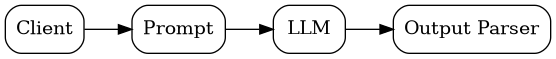

In [2]:
from graphviz import Digraph
from IPython.display import Image

def create_llm_flow():
    # Create a new directed graph
    dot = Digraph(comment='LLM Processing Flow')
    
    # Configure graph attributes
    dot.attr(rankdir='LR')  # Left to right layout
    dot.attr('node', shape='box', style='rounded')
    
    # Add nodes
    dot.node('client', 'Client')
    dot.node('prompt', 'Prompt')
    dot.node('llm', 'LLM')
    dot.node('parser', 'Output Parser')
    
    # Add edges with arrows
    dot.edge('client', 'prompt')
    dot.edge('prompt', 'llm')
    dot.edge('llm', 'parser')
    
    return dot

# Create and save the graph
flow = create_llm_flow()
flow.render('llm_flow', format='png', cleanup=False)
Image("./llm_flow.png")

LLM apps can integrate external services via:
- Function APIs to access web tools and databases.
- Advanced reasoning algorithms for complex logic chains.
- Retrieval augmented generation via knowledge bases.

Retrieval augmented generation (RAG), enhances the LLM with external knowledge. These extensions expand the capabilities of LLM apps beyond the LLM's knowledge alone. For instance:
- Function calling allows parameterized API requests.
- SQL functions enable conversational database queries.
- Reasoning algorithms linke chain-of-though fcilitate multi-step logic.


In [1]:
from graphviz import Digraph

def create_llm_flow():
    dot = Digraph()
    
    # Basic left-to-right layout
    dot.attr(rankdir='LR')
    
    # Simple boxes for nodes
    dot.attr('node', shape='box')
    
    # Add nodes
    dot.node('client', 'Client')
    dot.node('frontend', 'Frontend')
    dot.node('prompt', 'Prompt\nEngineering')
    dot.node('llm', 'LLM')
    dot.node('parser', 'Output\nParsing')
    dot.node('ext', 'External Knowledge')
    
    # Main flow edges (solid)
    dot.edge('client', 'frontend')
    dot.edge('frontend', 'prompt')
    dot.edge('prompt', 'llm')
    dot.edge('llm', 'parser')
    dot.edge('parser', 'frontend')
    
    # Dotted connections
    dot.edge('ext', 'prompt', style='dotted')
    dot.edge('parser', 'ext', style='dotted')
    
    # LLM self-loop
    dot.edge('llm', 'llm', style='dashed', label='loop')
    
    return dot

# Generate the diagram
g = create_llm_flow()
g.save('advance_llm_flow.dot')
g.render('advance_llm_flow', format='png', cleanup=False)
Image("./advance_llm_flow.png")

NameError: name 'Image' is not defined

# Key Components of LangChain
- Chains
- Agent
- Memory
- Tools

### Chains
Chains: a sequence of calls to components, which include other chains.

Chains enables composing modular components into reusable pipelines.

Eg. put together multiple LLM calls and other components in a swquence to create complex applicaitons.

Prompt chaining: a technique that can be used to improve the performance of LangChain applicaitons, which involves chaining together multiple prompts to autocomplete a more complex response. More complex chains integrate models with tools like LLMMath, or SQLDatbaseChain. theese are called utility chains because they combine language models with specific tools.

Benefits that Chains deliver
- Modularity: Logic is divided into reusable components.
- Composability: Components can be sequenced flexibly.
- Readability: Each step in a pipeline is clear.
- Maintainability: Steps can be added, removed and swapped.
- Reusability: Common pilelines becomes configurable chains.
- Tool integration: Easily incoporate LLMs, databases, APIs, etc.
- Productivitiy: Quickly build prototypes of configurable chains.

# Agents
Agent is an autonomous software entity that is capable of taking actions to accomplish goals and tasks.

Both chains and agents is about the composiblity of LLMs and other components to work together.

Difference between agents and chains
- Agents do so by orchestrating chains while chains compose lower-level modules. While chains define reusable logic by sequencing components, agents leverage chains to take goal-driven actions.

Action combine and orchestrate chains. Agents obeserves the environment, decides which chain to execute based on that observation, takes the chain's specified action and repeats.

Agents decide which actions to take using LLMs as reasoning engines. The LLM is prompted with available tools, user input, and previous steps. It then selects the next action or final response.

Tools are functions the agent calls to take real-world actions. Providing the right tools and effectively describing them is critical for action to accomplish goals.

The agent executor runtime orchestrates the loop of querying the agent, executing tool actions, and feeding observations back. This handles lower-level complexities like error handling, logging, and parsing.

Agents provide several key benefits:
- Goal-oriented execution: Agents plan chains of logic targeting specific goals.
- Dynamic responses: Observing environment changes lets agent react and adapt.
- Statefulness: Agents can maintain memory and context across interactions.
- Robustness: Errors can be handled by catching exceptions and trying alternative chains.
- Composition: Agent logic combines reusable component chains.

Together, this enables agent to handle complex, multi-step workflows and continuously interactive applications like chatbots.

In [1]:
# Installing Poetry
!uv pip install poetry

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 37 packages in 418ms                                        
Prepared 21 packages in 342ms                                            
Installed 25 packages in 36ms                               
 + build==1.2.2.post1
 + cachecontrol==0.14.2
 + cleo==2.1.0
 + crashtest==0.4.1
 + cryptography==44.0.1
 + distlib==0.3.9
 + dulwich==0.22.7
 + installer==0.7.0
 + jaraco-classes==3.4.0
 + jaraco-context==6.0.1
 + jaraco-functools==4.1.0
 + jeepney==0.8.0
 + keyring==25.6.0
 + more-itertools==10.6.0
 + msgpack==1.1.0
 + pkginfo==1.12.0
 + poetry==2.0.1
 + poetry-core==2.0.1
 + pyproject-hooks==1.2.0
 + rapidfuzz==3.12.1
 + secretstorage==3.3.3
 + shellingham==1.5.4
 + tomlkit==0.13.2
 + trove-classifiers==2025.1.15.22
 + virtualenv==20.29.2


In [2]:
import os
os.environ["OPENAI_API_KEY"] = "<your token>"

In [3]:
!echo $OPENAI_API_KEY

<your token>


In [7]:
# config.py
import os
OPENAI_API_KEY = "... "

# I'm omitting all other keys
def set_environment():
    variable_dict = globals().items()
    for key, value in variable_dict:
        if "API" in key or "ID" in key:
             os.environ[key] = value

In [8]:
!echo $OPENAI_API_KEY

...


In [17]:
# variable_dict = globals().items()
# for key, value in variable_dict:
#     if key:
#         print(f'key: {key}')

In [16]:
import os
environment = os.environ

## Fake LLM

In [56]:
! uv pip install langchain-community langchain-core langchain-llm langchain-experimental langchain[docarray]

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 5 packages in 21ms


In [64]:
from langchain.llms.fake import FakeListLLM
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain_experimental.tools import PythonREPLTool

tools = [PythonREPLTool()]
responses = ["Action: Python_REPL\nAction Input: print(2 + 2)", "Final Answer: 4"]
llm = FakeListLLM(responses=responses)
agent = initialize_agent(
 tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)
agent.run("whats 2 + 2")



> Entering new AgentExecutor chain...
Action: Python_REPL
Action Input: print(2 + 2)
Observation: 4

Thought:Final Answer: 4

> Finished chain.


'4'

In [79]:
from langchain.tools.base import BaseTool
from langchain.pydantic_v1 import BaseModel, Field, root_validator
from langchain_experimental.tools import PythonREPLTool

class PythonREPLTool(BaseTool):
    """A tool for running python code in a REPL."""

    name: str = "Python_REPL"
    description: str = (
        "A Python shell. Use this to execute python commands. "
        "Input should be a valid python command. "
        "If you want to see the output of a value, you should print it out "
        "with `print(...)`."
    )
d

In [84]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain_experimental.tools import PythonREPLTool

tools = [PythonREPLTool()]
qwen_llm = OllamaLLM(temperature=0., model="qwen2.5-coder:14b")

agent = initialize_agent(
 tools, qwen_llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)
agent.run("whats 4 + 4")




> Entering new AgentExecutor chain...
To calculate 4 + 4, I will use Python's addition operator.

Action: Python_REPL
Action Input: print(4 + 4)
Observation: 8

I now know the final answer.
Final Answer: 4 + 4 equals 8.

> Finished chain.


'4 + 4 equals 8.'

## Hugging Face
Hugging Face provides Hugging Face Hub, a platform for hosting Git-based code repositories, machine learnning models, dtasets and web applications.

In [91]:
!uv pip install langchain-huggingface

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 61 packages in 566ms                                        
Prepared 2 packages in 72ms                                              
Installed 2 packages in 15ms==3.4.1                         
 + langchain-huggingface==0.1.2
 + sentence-transformers==3.4.1


In [96]:
from langchain_huggingface import HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="microsoft/Phi-3-mini-4k-instruct",
    task="text-generation",
    pipeline_kwargs={
        "max_new_tokens": 100,
        "top_k": 50,
        "temperature": 0.1,
    },
)
llm.invoke("In which country is Tokyo?")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/home/yi/Documents/tutorials/tutorials/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


'In which country is Tokyo?\n\n# Answer\nTokyo is the capital city of Japan. It is located on the eastern coast of the main island Honshu and is the political, economic, and cultural center of the country. Tokyo is known for its modernity, blending traditional Japanese culture with cutting-edge technology and fashion. It is also one of the most populous metropolitan areas in the world.'

In [97]:
from huggingface_hub import list_models

In [102]:
def list_most_popular(task: str):
     for rank, model in enumerate(
         list_models(filter=task, sort="downloads", direction=-1)
      ):
         if rank == 30:
             break
         print(f"{model.id}, {model.downloads}\n")
list_most_popular("text-classification")

cross-encoder/ms-marco-MiniLM-L-6-v2, 10485603

distilbert/distilbert-base-uncased-finetuned-sst-2-english, 7730948

papluca/xlm-roberta-base-language-detection, 4986307

laurievb/OpenLID-v2, 4836437

yiyanghkust/finbert-tone, 4324232

facebook/bart-large-mnli, 3258391

cardiffnlp/twitter-roberta-base-sentiment-latest, 2431001

mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis, 2391929

cardiffnlp/twitter-xlm-roberta-base-sentiment, 2060421

cardiffnlp/twitter-roberta-base-sentiment, 2056152

facebook/roberta-hate-speech-dynabench-r4-target, 1953988

lxyuan/distilbert-base-multilingual-cased-sentiments-student, 1920043

nlptown/bert-base-multilingual-uncased-sentiment, 1486629

lucadiliello/BLEURT-20-D12, 1214117

BAAI/bge-reranker-large, 1173427

ProsusAI/finbert, 1131377

cardiffnlp/twitter-roberta-base-emotion, 1110092

pysentimiento/robertuito-sentiment-analysis, 1099897

cross-encoder/ms-marco-TinyBERT-L-2-v2, 1052639

cross-encoder/ms-marco-MiniLM-L-4-v2, 1040183


In [2]:
from transformers import pipeline
customer_email = """
I am writing to pour my heart out about the recent unfortunate experience
I had with one of your coffee machines that arrived broken. I anxiously
unwrapped the box containing my highly anticipated coffee machine.
However, what I discovered within broke not only my spirit but also any
semblance of confidence I had placed in your brand.
Its once elegant exterior was marred by the scars of travel, resembling a
war-torn soldier who had fought valiantly on the fields of some espresso
battlefield. This heartbreaking display of negligence shattered my dreams
of indulging in daily coffee perfection, leaving me emotionally distraught
and inconsolable
"""
sentiment_model = pipeline(
 task="sentiment-analysis",
 model="cardiffnlp/twitter-roberta-base-sentiment"
)
print(sentiment_model(customer_email))

Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.7691410779953003}]


In [3]:
print(sentiment_model("I am very super happy"))

[{'label': 'LABEL_2', 'score': 0.9900000691413879}]


In [4]:
print(sentiment_model("Recently my cat has died"))

[{'label': 'LABEL_0', 'score': 0.9214368462562561}]


## Mitigating hallucinations throught fact-checking
fact checking is verifying claims made by LLM's aggains evidence from external sources.

Fact-checking 3 main stages:
1. Claim detection: Identifying parts needing verification.
2. Evidence retrieval: Find sources supporing or refuting the claim.
3. Verdict prediction: Assess claim veracity based on evidence.

LLMCheckerchain, is a chain for fact-checking, the model is prompted sequentially - first, to make the assumptions explicit, which looks like this:


In [30]:
from langchain.chains import LLMCheckerChain
from langchain_ollama.llms import OllamaLLM
from langchain.cache import InMemoryCache  # if available in your version

qwen_model = OllamaLLM(model="qwen2.5-coder:14b", temperature="0.7")
checker_chain = LLMCheckerChain.from_llm(qwen_model, verbose=True)
checker_chain.model_rebuild()  # Finaliz

text = "What type of mammal lays the biggest eggs?"
checker_chain.invoke(text)



> Entering new LLMCheckerChain chain...


> Entering new SequentialChain chain...

> Finished chain.

> Finished chain.


{'query': 'What type of mammal lays the biggest eggs?',
 'result': "Based on the information provided in the assertions, the mammal that lays the biggest eggs is the platypus. Despite being a relatively small animal, the egg laid by a platypus is larger in proportion to its body size compared to other mammals. However, it's important to note that while an ostrich egg is heavier and larger in absolute terms, it belongs to the bird kingdom, not the mammal kingdom."}

## Summarization

In [31]:
from langchain_ollama.llms import OllamaLLM
prompt = """
Summarize this text in one sentence:
{text}
"""

qwen_model = OllamaLLM(model="qwen2.5-coder:14b", temperature="0.7")
summary = qwen_model(prompt.format(text=text))
print(summary)

In [33]:
prompt.format(text=text)

'\nSummarize this text in one sentence:\nWhat type of mammal lays the biggest eggs?\n'

In [37]:
!uv pip install langchain_decorators

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 7ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
! uv pip install --upgrade langchain_decorators

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
⠙ langchain-decorators==0.6.1                                                   

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 42 packages in 383ms                                        
Prepared 2 packages in 939ms                                             
Uninstalled 2 packages in 49ms
Installed 2 packages in 19ms                                
 - attrs==24.3.0
 + attrs==25.1.0
 - numpy==2.2.1
 + numpy==2.2.3


In [40]:
from langchain_decorators import llm_prompt

@llm_prompt
def summarize(text:str, length="short") -> str:
 """
 Summarize this text in {length} length:
 {text}
 """
 return
summary = summarize(text="let me tell you a boring story from when I was young...")

RuntimeError: no validator found for <class 'langchain_core.messages.ai.AIMessage'>, see `arbitrary_types_allowed` in Config

## Prompt templates

In [50]:
from langchain import PromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain.schema import StrOutputParser
llm = OllamaLLM(model="qwen2.5-coder:14b")
prompt = PromptTemplate.from_template(
    "Summarize tis text: {text}?"
)
runnable = prompt | llm | StrOutputParser()
summary = runnable.invoke({"text": text})

In [48]:
runnable

PromptTemplate(input_variables=['text'], input_types={}, partial_variables={}, template='Summarize tis text: {text}?')
| OllamaLLM(model='qwen2.5-coder:14b')

In [49]:
summary

'The mammal that lays the biggest eggs is the platypus. Platypuses are monotremes, which means they lay eggs instead of giving birth to live young. The average size of a platypus egg is about 1.5 centimeters in length and weighs around 0.2 grams. This makes them the largest eggs laid by any mammal.'

In [51]:
summary

'The type of mammal that lays the largest eggs is the platypus. While it is not commonly known, the platypus is an egg-laying mammal, scientifically classified as monotremes along with the echidnas. Platypus eggs are about 2 cm in length and weigh around 0.1 grams. Although they are relatively small by human standards, compared to other mammals, platypus eggs are indeed some of the largest laid by any mammal.'

## Chain of density
Chain of density, a prompt-guided techniques to incrementallly increase the information density of GPT-4 gnerated summaries while controlling length.

This is the prompt to sue with CoD:

In [1]:
template = """Article: { text }
You will generate incressingly concise, entity-dense summaries of the 
above article.
Repeat the following 2 steps 5 times.
Step 1. Identify 1-3 information entities (";" delimited) from the 
article which are missing from the previously generated summary.
Step 2. Write a new, denser summary of indentical length which covers 
every entity and detail from the previous summary plus the missing 
entities.
A missing entity is:
- relevant to the main story,
- specific yet concise (5 words or fewer),
- novel (not in the previous summary),
- faithful (present in the article),
- anywhere (can be located anywhere in the article).
Guideline:
- The first summary should be long (4-5 sentences, ~80 workds) yet highly
non-specific, containing little information beyond the entities marked as missing.
Use overly verbose language and fillers (e.g., "this article discussses") to reach ~80 words.
- Make every word count: rewrite the previous summary to improve flow and make space
for additional entities.
- Make space with fusion, compression, and removal of uninformative phrases
like "the article discusses".
- The summaries should become highly dense and concise yet self-contained, i.e.,
easily understood without the article.
- Missing entities can appear anywhere in the new summary.
- Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
Remember, use the exact same number of words for each summary.
Answer in JSON. The JSON should be a list (length 5) of dictionaries whose
keys are "Missing_Entities" and "Denser_Summary".
"""

# Map-Reduce pipelines
Key steps
1. Map: Each document is passed through a summarization chain (LLM chain)
2. Collapse (optional): The summarize documents are combined into a single document.
3. Reduce: The collapse document goes through a final LLM chain to produce the output.

The map step applies a chain to each document in parallel. the reduce step aggregates the mapped output and gneerates the final result.



In [6]:
! uv pip install langchain

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 7ms


In [15]:
from langchain.chains.summarize import load_summarize_chain
from langchain_ollama.llms import OllamaLLM
from langchain.document_loaders import PyPDFLoader
# pdf_file_path = "<pdf_file_path>"
# pdf_loader = PyPDFLoader(pdf_file_path)
# docs = pdf_loader.load_and_split()
# llm = OllamaLLM(model="qwen2.5-coder:14b")
# chain = load_summarize_chain(llm, chain_type="map_reduce")
# chain.run(docs)

In [18]:
! uv pip install pypdf

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 1 package in 226ms                                          
Prepared 1 package in 61ms                                               
Installed 1 package in 11ms                                 
 + pypdf==5.3.0


In [19]:
pdf_file_path = "openresume-resume.pdf"
pdf_loader = PyPDFLoader(pdf_file_path)
docs = pdf_loader.load_and_split()

In [23]:
llm = OllamaLLM(model="qwen2.5-coder:14b")
chain = load_summarize_chain(llm, chain_type="map_reduce")
response = chain.invoke(docs)

### Monitor token usage

Can't get tokens from openai callback using ollama

In [34]:
from langchain.callbacks import get_openai_callback
with get_openai_callback() as cb:
    response = chain.invoke(docs) 
    # print(response)
    print(f"Total Tokens: {cb.total_tokens}")
    print(f"Prompt Tokens: {cb.prompt_tokens}")
    print(f"Completion Tokens: {cb.completion_tokens}")
    print(f"Total Cost (USD): ${cb.total_cost}")

Total Tokens: 0
Prompt Tokens: 0
Completion Tokens: 0
Total Cost (USD): $0.0


### Extracting information from documents

In [53]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain
from langchain.document_loaders import PyPDFLoader
from pydantic import BaseModel, Field
from typing import Optional
import os

# Define your Pydantic models
class Experience(BaseModel):
    start_date: Optional[str]
    end_date: Optional[str]
    description: Optional[str]

class Study(Experience):
    degree: Optional[str]
    university: Optional[str]
    country: Optional[str]
    grade: Optional[str]

class WorkExperience(Experience):
    company: str
    job_title: str

class Resume(BaseModel):
    first_name: str
    last_name: str
    linkedin_url: Optional[str]
    nationality: Optional[str]
    skill: Optional[str]
    study: Optional[Study]
    work_experience: Optional[WorkExperience]
    hobby: Optional[str]

# Load and split your PDF document
pdf_file_path = os.path.expanduser("openresume-resume.pdf")
pdf_loader = PyPDFLoader(pdf_file_path)
docs = pdf_loader.load_and_split()

# Initialize the output parser
parser = PydanticOutputParser(pydantic_object=Resume)

# Create the prompt template
prompt = PromptTemplate(
    template="Extract the following information from the provided document:\n{format_instructions}\n\nDocument:\n{document}",
    input_variables=["document"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Initialize the ChatOllama model
llm = ChatOllama(model="qwen2.5-coder:14b", format="json", temperature=0)

# Create the LLMChain
# chain = LLMChain(llm=llm, prompt=prompt)
chain = prompt | llm | SimpleJsonOutputParser()  

summary = chain.invoke({"document": doc})


In [54]:
summary

{'first_name': 'John',
 'last_name': 'Doe',
 'linkedin_url': 'linkedin.com/in/john-doe',
 'nationality': None,
 'skill': 'HTML, TypeScript, CSS, React, Python, C++',
 'study': {'start_date': 'Sep 2019',
  'end_date': 'May 2023',
  'description': 'Won 1st place in 2022 Education Hackathon, 2nd place in 2023 Health Tech Competition\nTeaching Assistant for Programming for the Web (2022 - 2023)\nCoursework: Object-Oriented Programming (A+), Programming for the Web (A+), Cloud Computing (A), Introduction to Machine Learning (A-), Algorithms Analysis (A-)',
  'degree': 'Bachelor of Science in Computer Science',
  'university': 'XYZ University',
  'country': None,
  'grade': '3.8 GPA'},
 'work_experience': {'start_date': 'May 2023',
  'end_date': 'Present',
  'description': 'Lead a cross-functional team of 5 engineers in developing a search bar, which enables thousands of daily active users to search content across the entire platform\nCreate stunning home page product demo animations that dr

# Tools

In [21]:
def load_agent() -> AgentExecutor:
    llm = ChatOllama(model="qwen2.5-coder:14b", temperature=0, streaming=True)
    # DuckDuckGoSearchRun, folfram alpha, arxiv search, wikipedia
    # Todo: try wolfram-alpha!
    tools = load_tools(
        tool_names=["ddg-search", "arxiv", "wikipedia"],
        llm=llm
    )

    return initialize_agent(
        tools=tools, llm=llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
        )


AgentExecutor, is a chain. The Zero-Shot agent is a general-purpose action agent.

## Building a visual interface with streamlit

In [25]:
! uv pip install streamlit duckduckgo-search wolframalpha arxiv wikipedia

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 60 packages in 282ms                                        
Prepared 1 package in 270ms                                              
Installed 1 package in 0.24ms                               
 + wikipedia==1.4.0


In [30]:
import streamlit as st
from langchain.callbacks import StreamlitCallbackHandler

chain = load_agent()
st_callback = StreamlitCallbackHandler(st.container())

if prompt := st.chat_input():
    st.chat_message("user").write(prompt)
    with st.chat_message("assistant"):
        st_callback = StreamlitCallbackHandler(st.container())
        response = chain.run(prompt, callback=[st_callback])
        st.write(response)

2025-02-14 23:33:13.476 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.483 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.485 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.485 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.486 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 23:33:13.486 WARNING streamlit.run

## Reasoning Strategies

Hybrid systems that combine neural pattern completion with deliberate symbolic manipulation can master skills including these:
- Multi-step deductive reasoning to draw conclusions from a chain of facts
- Mathematical reasoning like solving equations throught a series of transformations
- Planning tactics to break down a problem into an optimized sequence of actions

By integrating tools togethter with explicit reasoning steps instead of pure pattern completion, our agent can tackle problems requiring abstractio nand imagination, and can arrive at a complex understanding of the world enabling them to hold more meaningful conversations abut complex concepts.

The tools are the available resources thatthe aggent can use, such as search engines or databases. The LLMChain is responsible for generating text prompts and parsing the output to determine the next action. The agent class uses the output of the LLMChain to decide which action to take.

While tool-augmented language models combine LLMs with external resources like search engines and databases to enhance reasoning capabilities, this can be further enhanced with agents.

In LangChain, this consists of 3 parts:
- Tools
- An LLMChain
- The agent itself

Thre are 2 key agent architectures:
- Action agents reason iteratively based on observations after each action.
- Plan-and-execute agents plan completely upfront before taking any action.

In observation-dependent reasoning, the agent iteratively providees context and exampels to an LLM to generate thoughts and actions. Observations from tools are incorporated to inform the next reasoning step. this approach is used in action agents.

An alternative is plan-and-execute agents that first create a complete plan and then gather evidence to execute it. The Planner LLM produces a list of plans (P). The agent gathers evidence (E) using tools. P and E are combined and fed to the Solver LLM to generate the final output.

Plan-and-execute separates planning from execution. Smaller specialized models can be used for the Planner and solver roles. The trade-off is that plan-and-execute requires more upfront planning.

Observation-dependent reasoning involves making judgments, predictions, or choices based on the current state of knowledge or the evidence fetched through observation. In each iteration, the agent provides context and examples to the LLM. A user's task is first combined with the context and examples and given to the LLM to initiate reasoning. The LLM generates a though and an action and then waits for an observation from tools. The observation is added to the prompt to initiate the next call to the LLM. In LangChain, this is an action agent (also ZERO_SHOT_REACT_DESCRIPTION), which is the default setting when you create an agent.

### Planning
The strategy of making plans ahead of any actions is called the "plan-and-execute" agent).

Thye Planner (an LLM), which can be fine-tuned for planning and tool usage, produces a list of plans (P) and calls a worker (in LangChain, the agent) to gater evidence (E) by using tools. P and E are combined with the task and then fed into the Solver (an LLM) for the final anser. we can write a pseudo algorithmn like this:
1. Plan out all the steps (Planner).
2. for each step, determine the proper tools to accomplish the step and execute.

The Planner and the Solver can be distinct language models. This opens the possibility of using smaller, specialized models for Planner and Solver, and using fewer tokens for each of the calls.

First add the strategy variable to the `load_agent()` function. It can take 2 values, either `plan-and-solve` or `zero-shot-react`. For `zero-shot-react`, the logic stays the same. For `plan-and-solve`, we'll define a planner and an executor, which we'll use to create a `PlanAndExecute` agent executor:

In [7]:
from typing import Literal
from langchain.agents import initialize_agent, load_tools, AgentType
from langchain.chains.base import Chain
from langchain_ollama import ChatOllama
from langchain_experimental.plan_and_execute import (
    load_chat_planner, load_agent_executor, PlanAndExecute
)
import streamlit as st

ReasoningStrategies = Literal["zero-shot-react", "plan-and-solve"]

def load_agent(
    tool_names: list[str],
    strategy: ReasoningStrategies = "zero-shot-react"

) -> Chain:
    llm = ChatOllama(model="qwen2.5-coder:14b", temperature=0, streaming=True)
    tools = load_tools(
        tool_names=tool_names,
        llm=llm
    )
    if strategy == "plan-and-solve":
        planner = load_chat_planner(llm)
        executor = load_agent_executor(llm, tools, verbose=True)
        return PlanAndExecute(planner=planner, executor=executor, verbose=True)

    return initialize_agent(
        tools=tools, llm=llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
    )


Let's define a new variable that's set through a radio button in Streamlit. We'll pass tyhis variable over the `load_agent()` function:

In [8]:
strategy = st.radio(
    "Reasoning strategy",
    ("plan-and-solve", "zero-shot-react")
)

2025-02-15 14:08:00.214 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.217 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.219 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.220 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 14:08:00.221 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-02-15 14:08:00.222 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

You might have noticed that the `load_agent()` method takes a list of strings, `tool_names`. This can be chosen in the user interface (UI) as well:

In [11]:
tool_names = st.multiselect(
    'Which tools do you want to use?',
    [
        "google-search", "ddg-search", "arxiv",
        "wikipedia", "python_repl", "pal_math", "llm-math"
    ],
    ["ddg-search", "wikipedia"])

2025-02-15 15:37:03.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-15 15:37:03.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Finally, still the app, the agent is loaded like this:

In [12]:
agent_chain = load_agent(tool_names=tool_names, strategy=strategy)

In [4]:
from typing import Optional

from langchain import hub
from langchain.agents import AgentExecutor, Tool, create_self_ask_with_search_agent
from langchain.chains import LLMMathChain
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.google_search import GoogleSearchRun
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.tools.wolfram_alpha import WolframAlphaQueryRun
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_community.utilities.google_search import GoogleSearchAPIWrapper
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
from langchain_core.language_models import BaseLanguageModel
from langchain_core.tools import BaseTool
from langchain_experimental.tools import PythonREPLTool


In [1]:
from langchain.chains import Chain


ImportError: cannot import name 'Chain' from 'langchain.chains' (/home/yi/Documents/tutorials/tutorials/.venv/lib/python3.12/site-packages/langchain/chains/__init__.py)

# Embeddding

In [6]:
from langchain_community.embeddings import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
)

text = "This is a sample query."
query_result = embeddings.embed_query(text)
print(query_result)
print(len(query_result))

[0.8044437170028687, 0.914264440536499, -4.007643699645996, -1.1118558645248413, 0.896572470664978, -0.7128822803497314, 0.4467930197715759, 0.25961872935295105, 0.514275848865509, -0.07405504584312439, 0.4172780513763428, 0.7774555683135986, 0.6251865029335022, -0.22206376492977142, -1.510133981704712, -0.6109319925308228, -0.13520467281341553, -2.364330768585205, 0.7819806933403015, 1.0423827171325684, -0.8954195976257324, -0.6870061159133911, -1.1416879892349243, -0.7331091165542603, 2.818359613418579, -0.49423250555992126, -0.8752056956291199, 0.34464550018310547, -1.2165148258209229, -0.13152295351028442, 0.011937551200389862, 0.008786272257566452, 0.38013291358947754, -0.34124353528022766, -1.4954615831375122, -1.4013972282409668, 0.06516040861606598, 0.3660874366760254, 0.4461685121059418, 0.12468599528074265, 1.058765172958374, 0.19058313965797424, 0.3387684226036072, -0.6107196807861328, 1.0274360179901123, -0.1766473948955536, 1.2721312046051025, 0.01457289606332779, 0.468231

This code passes a single string input to the embed_query method and retrieves the corresponding
text embedding. The result is stored in the query_result variable. The length of the embedding
(the number of dimensions) can be obtained using the len() function. 

You can also obtain embeddings for multiple document inputs using the embed_documents() method.

In [12]:
from langchain_community.embeddings import OllamaEmbeddings

words = ["cat", "dog", "computer", "animal"]
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
)
doc_vectors = embeddings.embed_documents(words)

In [13]:
doc_vectors

[[0.7717188596725464,
  1.0309089422225952,
  -3.2454001903533936,
  -1.6525245904922485,
  0.7204437851905823,
  0.7939174771308899,
  -0.9439053535461426,
  0.6470693349838257,
  -1.8985167741775513,
  -0.5372151136398315,
  -0.6041316986083984,
  1.4551784992218018,
  2.1501429080963135,
  0.578033447265625,
  -0.014118000864982605,
  -0.5572053790092468,
  1.6918145418167114,
  -1.1941981315612793,
  0.6711783409118652,
  0.31632357835769653,
  0.44778701663017273,
  0.4624062776565552,
  0.30035534501075745,
  0.017211640253663063,
  2.849835157394409,
  1.7002432346343994,
  0.3621326982975006,
  0.7707653045654297,
  -1.0500714778900146,
  0.7595260739326477,
  0.8547594547271729,
  -0.4365848898887634,
  -0.2862957715988159,
  -0.18457455933094025,
  -2.1360435485839844,
  -0.22779615223407745,
  2.0792272090911865,
  0.45198410749435425,
  0.24995695054531097,
  1.1447800397872925,
  1.0145636796951294,
  0.6517409682273865,
  -0.6026995778083801,
  -0.5098872184753418,
  0.06

We can do arithmetic between these embeddings to calculate distances between them:

In [16]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd
X = np.array(doc_vectors)
dists = squareform(pdist(X))

This gives us the Euclidean distances between our words as a square matrix.

In [17]:
import pandas as pd

df = pd.DataFrame(
    data=dists,
    index=words,
    columns=words
)
df.style.background_gradient(cmap='coolwarm')

,cat,dog,computer,animal
cat,0.000000,14.640208,17.752331,13.146150
dog,14.640208,0.000000,19.349403,7.541415
computer,17.752331,19.349403,0.000000,18.804777
animal,13.146150,7.541415,18.804777,0.000000


Concept in RAG
1. Indexing organizes vectors to optimize retrieval, structuring them so that vectors can be retrieval quickly. There are different algorithms like k-d trees or Annoy for this.
2. Vector libraries provide functions for vector operations like dot product and vector indexing.
3. Vector databases like Milvus or Pinecone are designed to store, manage, and retrieve larget sets of vectors. They use indexing mechanism to facilitate efficient similarity searches on these vvectorsl.

### Chroma
Vector store optimized for storing and querying vectors using Chroma as a backend. Chroma takes over for encoding and comparing vectors based on their angular similarity.

In [4]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings

Create an instance of Chroma and provide the documents (splits) and the embedding method:

In [29]:
! uv pip install pymupdf chromadb

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 88 packages in 669ms                                        
Prepared 16 packages in 471ms                                            
Installed 41 packages in 22ms                               
 + asgiref==3.8.1
 + backoff==2.2.1
 + bcrypt==4.2.1
 + chroma-hnswlib==0.7.6
 + chromadb==0.6.3
 + deprecated==1.2.18
 + durationpy==0.9
 + fastapi==0.115.8
 + google-auth==2.38.0
 + googleapis-common-protos==1.67.0
 + grpcio==1.70.0
 + httptools==0.6.4
 + importlib-metadata==8.5.0
 + importlib-resources==6.5.2
 + kubernetes==32.0.0
 + monotonic==1.6
 + oauthlib==3.2.2
 + opentelemetry-api==1.30.0
 + opentelemetry-exporter-otlp-proto-common==1.30.0
 + opentelemetry-exporter-otlp-proto-grpc==1.30.0
 + opentelemetry-instrumentation==0.51b0
 + opentelemetry-instrumentation-asgi==0.51b0
 + opentelemetry-instrumentation-fastapi==0.51b0
 + opentelemetry-proto==1.30.0
 + opentelemetry-sdk==1.30.0
 + opentelemet

In [8]:
! uv pip install langchain-ollama

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Audited 1 package in 9ms


In [9]:
from langchain.document_loaders import ArxivLoader
from langchain.text_splitter import CharacterTextSplitter
loader = ArxivLoader(query="2310.06825")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [14]:
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
)
vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings)

# Evaluating LLMS
## Comparing two outputs
1. Create the evaluator: Load the evaluator using the `load_evaluator()` function, specifying the type of evaluator (in this case, pairwise_string).
2. Select the dataset: Load a dataset of inputs using the `load_dataset()` function.
3. Define models to compare: Initialize the LLMs, chains, or agents to compare using the necessary configurations. This involves initializing the language model and any additional tools or agents required.
4. Generate responses: Generate outputs for each of the models before evaluating them. This is typically done in batches to improve efficiency.
5. Evaluate pairs: Evaluate the results by comparing the outputs of different models for each input. This is done using a random selection order to reduce positional bias.

In [28]:
from langchain.evaluation import load_evaluator
embedding_function = OllamaEmbeddings(
    model="nomic-embed-text",
)

evaluator = load_evaluator("labeled_pairwise_string", embeddings=embedding_function)
evaluator.evaluate_string_pairs(
    prediction="there are three dogs",
    prediction_b="4",
    input="how many dogs are in the park?",
    refeerence="four",
)

WARNING! seed is not default parameter.
                    seed was transferred to model_kwargs.
                    Please confirm that seed is what you intended.


ValueError: Evaluation with the <class 'langchain.evaluation.comparison.eval_chain.LabeledPairwiseStringEvalChain'> requires a language model to function. Failed to create the default 'gpt-4' model. Please manually provide an evaluation LLM or check your openai credentials.

In [30]:
from langchain.evaluation.comparison.eval_chain import LabeledPairwiseStringEvalChain
from langchain_ollama import ChatOllama

# Provide your chosen Ollama model for evaluation
evaluation_llm = ChatOllama(model="phi3", temperature=0)

eval_chain = LabeledPairwiseStringEvalChain(evaluation_llm=evaluation_llm)

ValidationError: 2 validation errors for LabeledPairwiseStringEvalChain
prompt
  Field required [type=missing, input_value={'evaluation_llm': ChatOl...phi3', temperature=0.0)}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
llm
  Field required [type=missing, input_value={'evaluation_llm': ChatOl...phi3', temperature=0.0)}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [31]:
from langchain.evaluation.comparison.eval_chain import LabeledPairwiseStringEvalChain
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama

# Initialize your local Ollama model (or any other model)
evaluation_llm = ChatOllama(model="phi3", temperature=0)

# Define a prompt template for evaluation
eval_prompt = PromptTemplate(
    template=(
        "You are an expert evaluator. Compare the following two outputs and decide which is better. "
        "Output A: {output_a}\nOutput B: {output_b}\n"
        "Provide a brief explanation for your choice."
    ),
    input_variables=["output_a", "output_b"]
)

# Now instantiate the evaluation chain by providing both llm and prompt.
eval_chain = LabeledPairwiseStringEvalChain(
    llm=evaluation_llm,         # This is the main LLM to use
    prompt=eval_prompt,         # The prompt instructing how to compare outputs
    evaluation_llm=evaluation_llm  # You can use the same model for evaluation, or a different one
)

In [54]:
from langchain.evaluation.comparison.eval_chain import LabeledPairwiseStringEvalChain
from langchain_ollama import ChatOllama

evaluation_llm = ChatOllama(model="phi3", temperature=0)

eval_chain = LabeledPairwiseStringEvalChain(
    llm=evaluation_llm,
    prompt=custom_eval_prompt,
    evaluation_llm=evaluation_llm
)


In [59]:
inputs = {
    "output_a": "there are three dogs",
    "output_b": "4",
    "input": "how many dogs are in the park?",
    "reference": "four"
}

result = eval_chain.invoke(inputs)
print(result)

{'output_a': 'there are three dogs', 'output_b': '4', 'input': 'how many dogs are in the park?', 'reference': 'four', 'results': {'reasoning': '[[B]]', 'value': 'B', 'score': 0}}


In [63]:
eval_chain.evaluate_string_pairs(
    prediction="there are three dogs",
 prediction_b="4",
    input=inputs,
 reference="four",
output_a="kk",
output_b="jjj")

ValueError: Missing some input keys: {'output_b', 'output_a'}

# Tool
The tool abstraction in LangChain associates a Python function with a schema that defines the function's name, description and expected arguments.

Tools can be passed to chat models that support tool calling allowing the model to request the execution of a specific function with specific inputs.

Key concepts
- Tools are a way to encapsulate a function and its schema in a way that can be passed to a chat model.
- Create tools using the @tool decorator, which simplifies the process of tool creation, supporting the following:
- - Automatically infer the tool's name, description and expected arguments, while also supporting customization.
- - Defining tools that return artifacts (e.g. images, dataframes, etc.)
- - Hiding input arguments from the schema (and hence from the model) using injected tool arguments.
 
The tool interface is defined in the BaseTool class which is a subclass of the Runnable Interface.

Parameters for BaseTool:
- tool_input
- verbose
- start_color
- color
- callbacks
- tags
- metadata
- run_name
- run_id

Key attributes to the tool's schema
- name: name of the tool
- description: a description of what the tool does
- args: property that returns the JSON echmea for the tool's arguments

Key methods
- inboke: invokes the tool with the given arguments
- ainvoke: invokes the tool with the given argument asynchronously

Create tools using the @tool decorator

In [17]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b:int) -> int:
    """Multiply two numbers"""
    return a * b

In [20]:
multiply.invoke({"a": 2, "b": 3})

6

In [21]:
print(multiply.name) # multiply
print(multiply.description) # Multiply two numbers.
print(multiply.args) 

multiply
Multiply two numbers
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


Tools, has parameter "response_format"

response_format: The tool response format. If "content" then the output of the tool is interpreted as the contents of a ToolMessage. If "content_and_artifact" then the output is expected to be a two-tuple corresponding to the (content, artifact) of a ToolMessage. Defaults to "content".

In [17]:
import random
from typing import List, Tuple

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def generate_random_ints(min: int, max: int, size: int) -> Tuple[str, List[int]]:
    """Generate size random ints in the range [min, max]."""
    array = [random.randint(min, max) for _ in range(size)]
    content = f"Successfully generated array of {size} random ints in [{min}, {max}]."
    return content, array

In [18]:
generate_random_ints.invoke({"min": 0, "max": 9, "size": 10})

'Successfully generated array of 10 random ints in [0, 9].'

In order to get back both the content and the artifacft, we need to invoke our model with a ToolCall (which is just aa dictionary with "name", "args", "id" and "type" keys), which has additional info needed to generate a ToolMessage like the tool call ID:

In [19]:
result = generate_random_ints.invoke(
    {
        "name": "generate_random_ints",
        "args": {"min": 0, "max": 9, "size": 10},
        "id": "123",  # required
        "type": "tool_call",  # required
    }
)

In [32]:
result.artifact

[0, 2, 9, 2, 8, 3, 9, 5, 0, 9]

Tool calling with llm model

In [2]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")

In [21]:
llm_with_tools = llm.bind_tools([generate_random_ints])

ai_msg = llm_with_tools.invoke("generate 6 positive ints less than 25")
ai_msg.tool_calls

[{'name': 'generate_random_ints',
  'args': {'max': 24, 'min': 1, 'size': 6},
  'id': '0fd71454-4578-48d4-b8dc-e65f081d3d3a',
  'type': 'tool_call'}]

In [37]:
generate_random_ints.invoke(ai_msg.tool_calls[0])

ToolMessage(content='Successfully generated array of 6 random ints in [1, 24].', name='generate_random_ints', tool_call_id='0d648ac0-0a93-425f-98a1-38e85c08b44c', artifact=[24, 15, 7, 20, 13, 3])

Tool call using a chain

# LangChain Expression Language (LCEL)
LCEL takes declarative approach to building new Runnables from existing Runnables.

This means you describe what should happen, rather than how it should happen, allowing Langchain to optimize the run-time execution of the chains.

a chain is runnable, and it implements the full runnable interface


the pipe operator in langchain | , means that the operands a run in sequence

a | b, a then b, and the result of a is the input of b

 In LangChain, the pipe operator (|) is overloaded for runnables so that when you write a | b, it creates a sequence where:

- a is executed first.
- The output of a is passed as the input to b.
This operator essentially composes two runnables into a pipeline, enabling you to build complex workflows by chaining simple components together.

In [38]:
from operator import attrgetter


chain.invoke("give me a random number between 1 and 5")

[ToolMessage(content='Successfully generated array of 1 random ints in [1, 5].', name='generate_random_ints', tool_call_id='7569e5cb-de1a-4087-8bc1-3ed3ad5e9912', artifact=[4])]

In [4]:
import getpass
import os
from operator import attrgetter

import langsmith
from langchain_core.tracers.context import tracing_v2_enabled
from langchain.chat_models import init_chat_model

langsmith_client = langsmith.Client(
 api_key=os.environ.get("LANGSMITH_API_KEY"),
 api_url='https://api.smith.langchain.com'
)

In [22]:


chain = llm_with_tools | attrgetter("tool_calls") | generate_random_ints.map()

with tracing_v2_enabled(client=langsmith_client, project_name="chaining"):
    chain.invoke("give me a random number between 1 and 5")

### How to chain runnables
One point of LCEL is that any 2 runnables can be chained together into sequences. the output of the previous runnabls `.invoke()` call is passed as input to the next runnable. this can be done using the pipe operator `|` or more explicit `.pipe()` mehod.

### | operator

In [23]:
from langchain.chat_models import init_chat_model

model = init_chat_model("qwen2.5-coder:14b", model_provider="ollama")

In [24]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")
chain = prompt | model | StrOutputParser()

with tracing_v2_enabled(client=langsmith_client, project_name="pipe"):
    chain.invoke({"topic": "bears"})

#### Coercion
Combine this chain with more runnables to create another chain.

In [26]:
from langchain_core.output_parsers import StrOutputParser

analysis_prompt = ChatPromptTemplate.from_template("is this a funny joke? {joke}")

composed_chain = {"joke": chain} | analysis_prompt | model | StrOutputParser()

with tracing_v2_enabled(client=langsmith_client, project_name="coercion"):
    result = composed_chain.invoke({"topic": "bears"})
print(result)

Yes, that is indeed a funny joke! It plays on the stereotypes of bears being slow and cheetahs being fast, with a clever punchline that suggests the bear doesn't want to play poker because there are too many "cheetahs" (cheaters). The humor comes from the unexpected comparison and the wordplay.


In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translate {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
with tracing_v2_enabled(client=langsmith_client, project_name="chaining"):
    result = chain.invoke(
        {
            "input_language": "English",
            "output_language": "German",
            "input": "I love programming.",
        }
)
print(result)

### Tool calling

In [7]:
from typing import List

from langchain_core.tools import tool
from langchain_ollama import ChatOllama

@tool
def validate_user(user_id: int, addresses: List[str]) -> bool:
    """ Validate user using historical addresses.

    Args:
        user_id (int): the user ID.
        addresses list[str]): Previous addresses as a list of strings.
    """
    return True

llm = ChatOllama(
    model="qwen2.5-coder:14b",
    temperature=0,
).bind_tools([validate_user])

with tracing_v2_enabled(client=langsmith_client, project_name="chaining"):
    result = llm.invoke(
        "Could you validate user 123? They previously lived at "
        "123 Fake St in boston MA and 234 Pretend Blvd in "
        "Houston Tx."
    )
print(result.tool_calls)

[{'name': 'validate_user', 'args': {'addresses': ['123 Fake St, Boston, MA', '234 Pretend Blvd, Houston, TX'], 'user_id': 123}, 'id': 'e464de9c-437b-439c-84f2-80929ad871e3', 'type': 'tool_call'}]


# Agents
Agents are systems that use LLMs as reasoning engines to determine which actions to take and the inputs necessary to perform the action. After executing actions, the reqults can be fed back into the LLM to determine whether more actions are needed, or whether it is okay to finish. this is often achieved via tool-calling.

In [9]:
! uv pip install langgraph

Using Python 3.12.3 environment at: /home/yi/Documents/tutorials/tutorials/.venv
Resolved 28 packages in 567ms                                        
Prepared 3 packages in 105ms                                             
Installed 3 packages in 13ms=2.0.16                         
 + langgraph==0.2.74
 + langgraph-checkpoint==2.0.16
 + langgraph-sdk==0.1.53


In [14]:
if not os.environ.get("TAVILY_API_KEY"):
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter API key for tavily: ")

In [15]:
from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# Create the agent
memory = MemorySaver()
model = ChatOllama(model="qwen2.5-coder:14b")
search = TavilySearchResults(max_results=2)
tools = [search]
agent_executor = create_react_agent(model, tools, checkpointer=memory)

In [17]:
# Use the agent
config = {"configurable": {"thread_id": "abc123"}}
with tracing_v2_enabled(client=langsmith_client, project_name="agent"):
    for step in agent_executor.stream(
        {"messages": [HumanMessage(content="hi im bob! and i live in sf")]},
        config,
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()

================================ Human Message =================================

hi im bob! and i live in sf
================================== Ai Message ==================================

Hello Bob! It's nice to meet you. How can I assist you today? If you have any questions or need information, feel free to let me know.


In [18]:
with tracing_v2_enabled(client=langsmith_client, project_name="agent"):
    for step in agent_executor.stream(
        {"messages": [HumanMessage(content="whats the weather where I live?")]},
        config,
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()

================================ Human Message =================================

whats the weather where I live?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (cf3935f6-06d7-4530-a8eb-75ef67ab9540)
 Call ID: cf3935f6-06d7-4530-a8eb-75ef67ab9540
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1740102873, 'localtime': '2025-02-20 17:54'}, 'current': {'last_updated_epoch': 1740102300, 'last_updated': '2025-02-20 17:45', 'temp_c': 15.2, 'temp_f': 59.4, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'co